In [1]:
import numpy as np
def gradient_solver(emmap,gx,gy,gz,model_initial,g,friction,min_dist_in_angst,apix,
                  dt=0.05,capmagnitude_lj=400,epsilon=1,scale_lj=1,lj_factor=1,capmagnitude_map=100,scale_map=1,total_iterations=50, 
                  compute_map=False,emmap_path=None,mask_path=None,returnPointsOnly=True,verbose=False,
                  integration='verlet',myoutput=None, save_path=None, save_file_folder=None):
    '''
    Function to solve pseudoatomic model using gradient descent approach. 
    
    emmap : numpy.ndarray
        Numpy array containing the 3D volume of the map
    gx,gy,gz : numpy.ndarray
        Gradients obtained using numpy.gradient() method to get gradient information in x,y and z
    model_initial : pseudomodel_analysis.Model()
        Is a custom built class which has the coordinate information of all atoms. Also has several useful custom functions 
    g : float
        Gradient scaling parameter to scale the "accelerations" uniformly across the model
    friction : float
        friction coefficient to converge the model
    min_dist_in_angst : float
        Minimum distance between two atoms in the pseudo-atomic model, constrained by the bond lengths
    apix : float
        apix of the emmap
    
    -- special note for the following parameters --
    capmagnitude_lj, capmagnitude_map : float
        These values truncate the maximum acceleration felt by an atom during each iteration so that the analysis becomes bounded
        
    '''
    import gemmi
    import os
    from locscale.include.emmer.ndimage.map_tools import compute_real_space_correlation
    from locscale.include.emmer.pdb.pdb_to_map import pdb2map
    from locscale.include.emmer.ndimage.profile_tools import compute_radial_profile
    from locscale.include.emmer.pdb.pdb_utils import set_atomic_bfactors
    from locscale.include.emmer.pdb.modify_pdb import set_pdb_cell_based_on_gradient
    from locscale.preprocessing.pseudomodel_classes import Vector, add_Vector
    from locscale.preprocessing.pseudomodel_solvers import get_neighborhood, average_map_value, get_acceleration_from_gradient, get_acceleration_from_lj_potential
    from locscale.utils.plot_tools import tab_print
    from tqdm import tqdm

    tabbed_print = tab_print(2)
    tprint = tabbed_print.tprint
    map_values = []
    pseudomodel = model_initial.copy()
    gradient_magnitude = np.sqrt(gx**2+gy**2+gz**2)
    
    # convert the following into a dictionary solver_properties = 'Solver started with the following properties: \n'+'\n Number of atoms = '+str(len(pseudomodel.list))+'\n Map potential: \n'+'\n g = '+str(g)+'\n Max gradient magnitude  = '+str(gradient_magnitude.max())+'\n Map value range  = '+str((emmap.min(),emmap.max()))+'\n Cap magnitude at  = '+str(capmagnitude_map)+'\n LJ Potential: \n'+'\n Equilibrium distance = '+str(min_dist_in_angst)+'\n apix, in A = '+str(apix)+'\n LJ Factor = '+str(lj_factor)+'\n Epsilon = '+str(epsilon)+'\n Cap magnitude at  = '+str(capmagnitude_lj)+'\n Friction: \n'+ '\n Friction Coefficient = '+str(friction)+'\n Solver properties: \n'+'\n Total Iterations = '+str(total_iterations)+'\n Time step = '+str(dt)
    solver_properties_dictionary = {
        'num_atoms':len(pseudomodel.list),
        'map_potential':{
            'g':g,
            'max_gradient_magnitude':gradient_magnitude.max(),
            'map_value_range':(emmap.min(),emmap.max()),
            'cap_magnitude_at':capmagnitude_map
        },
        'lj_potential':{
            'equilibrium_distance':min_dist_in_angst,
            'apix_in_A':apix,
            'lj_factor':lj_factor,
            'epsilon':epsilon,
            'cap_magnitude_at':capmagnitude_lj
        },
        'friction':{
            'friction_coefficient':friction
        },
        'solver_properties':{
            'total_iterations':total_iterations,
            'time_step':dt

        }
    }
    
    ## print the solver properties in a nice format
    print('='*50,file=myoutput)
    print('Solver started with the following properties: ',file=myoutput)
    for key,value in solver_properties_dictionary.items():
        print(key+' = '+str(value), file=myoutput)
    print('='*50,file=myoutput)
  
    emmap_shape = emmap.shape
    unitcell = gemmi.UnitCell(emmap_shape[0]*apix,emmap_shape[1]*apix,emmap_shape[2]*apix,90,90,90)
    for iter in tqdm(range(total_iterations),desc="Building Pseudo-atomic model"):
        # Save a  copy of the model as PDB
        #save_file_folder = "/home/abharadwaj1/papers/elife_paper/figure_information/data/pseudomodel_during_iterations/hybrid_pseudomodel_iterations/pseudomodels/"
        save_file_name = "pseudoatomic_model_"+str(iter)+".pdb"
        save_file_path = os.path.join(save_file_folder,save_file_name)

        pseudomodel.write_pdb(save_file_path, apix=apix,unitcell=unitcell)

        neighborhood = get_neighborhood(pseudomodel.list,min_dist_in_angst/apix)
        
        point_id = 0
        for atom in pseudomodel.list:            
            lj_neighbors = [pseudomodel.list[k] for k in neighborhood[point_id][1]]
            
            gradient_acceleration,map_value = get_acceleration_from_gradient(gx,gy,gz,emmap, g, point=atom, capmagnitude_map=capmagnitude_map)
            if len(lj_neighbors)==0:
                lj_potential_acceleration,_ = Vector(np.array([0,0,0])),0
            else:
                lj_potential_acceleration,_ = get_acceleration_from_lj_potential(atom, lj_neighbors, epsilon=1, min_dist_in_pixel=min_dist_in_angst/apix,lj_factor=lj_factor,capmagnitude_lj=capmagnitude_lj)
            
            gradient_acceleration,lj_potential_acceleration = gradient_acceleration.scale(scale_map),lj_potential_acceleration.scale(scale_lj)
            acceleration = add_Vector(gradient_acceleration,lj_potential_acceleration)
            # add friction 
            atom.acceleration = add_Vector(acceleration, atom.velocity.scale(-friction))
            atom.map_value = map_value
            point_id += 1
        
        if not returnPointsOnly:
            map_values.append(average_map_value(pseudomodel.list))

        if integration == 'euler':
            for atom in pseudomodel.list:
                atom.velocity_from_acceleration(dt)        
                atom.position_from_velocity(dt)
                atom.update_history()
        
        elif integration == 'verlet':
            ''' 
            For the first iteration, use Euler integration since we have no information about -1'th time step
            ''' 
            if iter == 0: 
                for atom in pseudomodel.list:
                    atom.velocity_from_acceleration(dt)        
                    atom.position_from_velocity(dt)
                    atom.update_history()
            else:
                for atom in pseudomodel.list:
                    atom.verlet_integration(dt)
                    atom.update_history()
        else:
            continue 
    pseudomodel.apix = apix
    pseudomodel.update_pdb_positions(apix)
    if returnPointsOnly:
        return pseudomodel    
    else:
        return pseudomodel, map_values

In [2]:
from locscale.include.emmer.ndimage.map_utils import load_map, measure_mask_parameters, save_as_mrc
from locscale.include.emmer.ndimage.filter import get_cosine_mask
from scipy.ndimage import uniform_filter
from locscale.include.emmer.ndimage.map_tools import find_unmodelled_mask_region, estimate_global_bfactor_map_standard
import os 

input_folder = "/home/abharadwaj1/papers/elife_paper/figure_information/data/pseudomodel_during_iterations/hybrid_pseudomodel_iterations"
emmap_path = os.path.join(input_folder, "emd_8702_unsharpened_map.mrc")
mask_path = os.path.join(input_folder, "emd_8702_FDR_confidence_final.map")
pdb_path = os.path.join(input_folder, "cropped_model_pdb_5vkq.pdb")

emmap, apix = load_map(emmap_path)

global_bfactor_map = estimate_global_bfactor_map_standard(emmap_path=emmap_path, wilson_cutoff=9, fsc_cutoff=3.55)
print("Global B-factor map estimated: ", global_bfactor_map)

fdr_mask = load_map(mask_path)[0]
filtered_fdr_mask = uniform_filter(fdr_mask,size=3)
binarised_fdr_mask = (fdr_mask>0.99).astype(np.int_)
softmask = get_cosine_mask(binarised_fdr_mask,5)
difference_mask = find_unmodelled_mask_region(fdr_mask_path=mask_path, pdb_path=pdb_path, fdr_threshold=0.99, \
                                            atomic_mask_threshold=0.5, averaging_window_size=3, fsc_resolution=3.55)

save_as_mrc(difference_mask, os.path.join(input_folder, "difference_mask.mrc"), apix=apix)
threshold = 0.99
binarised_fdr_mask = difference_mask > 0.5


Global B-factor map estimated:  98.41317403449288


In [3]:
num_atoms, _ = measure_mask_parameters(mask=binarised_fdr_mask, apix=apix, edge_threshold=0.5)

Mask parameters calculated are: 
Mask sum voxels: 433745
Mask volume: 779123.978 A^3 
Protein mass: 1052 zg
Num atoms: 48205



In [4]:
from locscale.preprocessing.pseudomodel_classes import extract_model_from_mask
import gemmi
import os
### Extract a random pseudo-atomic model from the masked map ###
pseudomodel = extract_model_from_mask(binarised_fdr_mask,num_atoms,threshold=threshold)


emmap_shape = emmap.shape
unitcell = gemmi.UnitCell(emmap_shape[0]*apix,emmap_shape[1]*apix,emmap_shape[2]*apix,90,90,90)

outputlogfilepath = os.path.join(os.path.dirname(emmap_path),"pseudomodel_log.txt")
output_file = open(outputlogfilepath,"w")

gz,gy,gx = np.gradient(emmap)
masked_grad_magnitude = binarised_fdr_mask * np.sqrt(gx**2 + gy**2 + gz**2)
max_gradient = masked_grad_magnitude.max()

g = round(100 / max_gradient)
scale_lj = 1
scale_map = 1
friction = 10


# arranged_points = gradient_solver(
#    emmap,gx,gy,gz,pseudomodel,g=g,friction=friction,min_dist_in_angst=1.2,apix=apix,dt=0.1,
#    capmagnitude_lj=100,epsilon=1,scale_lj=scale_lj,capmagnitude_map=100,scale_map=scale_map,
#    total_iterations=50, compute_map=None,emmap_path=None,mask_path=None,
#    returnPointsOnly=True,integration='verlet',verbose=False, myoutput=output_file)

mask_name = mask_path[:-4]
pseudomodel_path = mask_name+"_gradient_pseudomodel.pdb"

In [5]:
from locscale.include.emmer.pdb.pdb_to_map import pdb2map
from locscale.include.emmer.pdb.pdb_utils import set_atomic_bfactors
from locscale.include.emmer.ndimage.map_utils import save_as_mrc
import joblib
import gemmi
output_pseudomodel_map_folder = os.path.join(input_folder, "pseudomodel_maps")
if not os.path.exists(output_pseudomodel_map_folder):
    os.mkdir(output_pseudomodel_map_folder)
    
input_pseudomodel_folder = os.path.join(input_folder, "pseudomodels")

pseudomodel_paths = [os.path.join(input_pseudomodel_folder, f) for f in os.listdir(input_pseudomodel_folder) if f.endswith(".pdb")]
# # rename the files to have ".mmcif" extension
# for pseudomodel_path in pseudomodel_paths:
#     os.rename(pseudomodel_path, pseudomodel_path[:-4]+".mmcif")
    
pseudomodel_paths = [os.path.join(input_pseudomodel_folder, f) for f in os.listdir(input_pseudomodel_folder) if f.endswith(".mmcif")]


# # run pdb2map in parallel 
# def create_modmap(input_pdb_path, apix, size, output_folder):
#     uniform_bfactor = global_bfactor_map
#     input_pdb_st = gemmi.read_structure(input_pdb_path)
#     uniform_bfactor_st = set_atomic_bfactors(input_gemmi_st=input_pdb_st, b_iso=uniform_bfactor)
#     simmap = pdb2map(uniform_bfactor_st, apix=apix, size=size)
#     output_map_path = os.path.join(output_folder,os.path.basename(input_pdb_path)[:-4]+".mrc")
#     save_as_mrc(simmap, output_map_path,apix=apix)

# n_jobs = 10
# joblib.Parallel(n_jobs=n_jobs,verbose=10)(
#     joblib.delayed(create_modmap)(
#         input_pdb_path, apix, emmap_shape, output_pseudomodel_map_folder) for input_pdb_path in pseudomodel_paths)






(150, 150, 150)


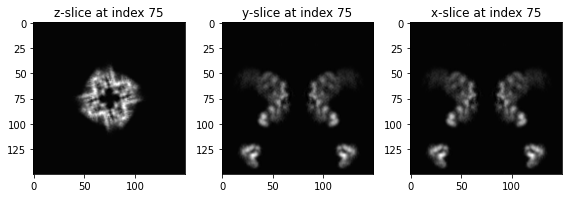

In [6]:
import matplotlib.pyplot as plt
center_z = 150
center_y = 200
center_x = 200
center = (center_z,center_y,center_x)
width = 150
height = width
depth = width
start_index_z = center_z - depth//2
end_index_z = center_z + depth//2
start_index_y = center_y - height//2
end_index_y = center_y + height//2
start_index_x = center_x - width//2
end_index_x = center_x + width//2
emmap_masked = emmap * softmask
boxed_out_map = emmap_masked[start_index_z:end_index_z,start_index_y:end_index_y,start_index_x:end_index_x]
print(boxed_out_map.shape)  
fig, ax = plt.subplots(1,3,figsize=(8,8))
index = width//2

ax[0].imshow(boxed_out_map[index,:,:] , cmap='gray')
ax[0].set_title("z-slice at index {}".format(index))
ax[1].imshow(boxed_out_map[:,index,:] , cmap='gray')
ax[1].set_title("y-slice at index {}".format(index))
ax[2].imshow(boxed_out_map[:,:,index], cmap='gray')
ax[2].set_title("x-slice at index {}".format(index))


plt.tight_layout()

# fig, ax = plt.subplots(1,3,figsize=(8,8))
# index = width//2

# ax[0].imshow(simmap_crop[index,:,:] , cmap='gray')
# ax[0].set_title("z-slice at index {}".format(index))
# ax[1].imshow(simmap_crop[:,index,:] , cmap='gray')
# ax[1].set_title("y-slice at index {}".format(index))
# ax[2].imshow(simmap_crop[:,:,index], cmap='gray')
# ax[2].set_title("x-slice at index {}".format(index))

# plt.tight_layout()


In [7]:
# extract the radial profiles for each map in the folder
import os
import numpy as np
from locscale.include.emmer.ndimage.profile_tools import compute_radial_profile, frequency_array
from locscale.include.emmer.ndimage.map_utils import load_map, resample_image
from locscale.include.emmer.ndimage.fsc_util import calculate_fsc_maps, calculate_amplitude_correlation_maps
from tqdm import tqdm
iterations = list(np.arange(0,50))

pseudomodel_paths = [os.path.join(input_pseudomodel_folder, f) for f in os.listdir(input_pseudomodel_folder) if f.endswith(".pdb")]

pseudomodel_map_paths = {i:os.path.join(output_pseudomodel_map_folder, f"pseudoatomic_model_{i}.m.mrc") for i in iterations}
simmap_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/pseudomodel_during_iterations/hybrid_pseudomodel_iterations/pdb5vkq_uniform_bfactor.mrc"
simmap, _ = load_map(simmap_path)
simmap_masked = softmask * simmap
reference_emmap_cropped = simmap_masked[start_index_z:end_index_z,start_index_y:end_index_y,start_index_x:end_index_x]
radial_profiles_iterations = {}
fsc_average_iterations = {}
amplitude_correlation_iterations = {}
wilson_fsc_average_iterations = {}
for i in tqdm(iterations):
    simmap, apix = load_map(pseudomodel_map_paths[i])
    simmap_pseudo_mask = simmap * softmask
    simmap_crop = simmap_pseudo_mask[start_index_z:end_index_z,start_index_y:end_index_y,start_index_x:end_index_x]
    fsc_cropped = calculate_fsc_maps(boxed_out_map, simmap_crop) 
    fsc_average_iterations[i] = np.mean(fsc_cropped)
    wilson_fsc_average_iterations[i] = np.mean(fsc_cropped[:18])
    
    radial_profile = compute_radial_profile(simmap_crop)
    radial_profiles_iterations[i] = radial_profile

freq = frequency_array(radial_profile, apix=apix)


100%|██████████| 50/50 [01:54<00:00,  2.29s/it]


In [8]:
def pretty_lineplot_XY(xdata, ydata, xlabel, ylabel, figsize=(14,8), \
                        marker="o", markersize=12,fontscale=2.5,font="Helvetica", \
                        linewidth=2,legends=None):
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import cm
    import seaborn as sns    
    from matplotlib.pyplot import cm
    import matplotlib as mpl
    ## Function not generic
    mpl.rcParams['pdf.fonttype'] = 42
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.set_theme(context="paper", font=font, font_scale=fontscale)
    sns.set_style("white")
    sns.lineplot(x=xdata,y=ydata,linewidth=linewidth,marker=marker,markersize=markersize, ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel, rotation=90, ha="center")

    if legends is not None:        
        ax.legend(legends)
    plt.tight_layout()

    return fig

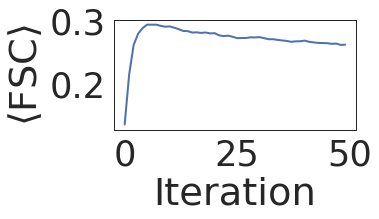

In [22]:
fig = pretty_lineplot_XY(xdata=fsc_average_iterations.keys(), ydata=fsc_average_iterations.values(), xlabel="Iteration", ylabel=r"$\langle$FSC$\rangle$", figsize=(6,4), \
                        marker="", markersize=12,fontscale=4,font="Helvetica")
# add x ticks 0 25 50
fig.axes[0].set_xticks([0,25,50])
fig.savefig(os.path.join(input_folder, "fsc_vs_iteration_unsharp.eps"), dpi=600, bbox_inches='tight')

In [51]:
refined_modmap_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/pseudomodel_during_iterations/hybrid_pseudomodel_iterations/PDB_5vkq_unrefined_shifted_servalcat_refined_shifted_servalcat_refined_shifted_bfactors..m_4locscale.mrc"
fsc_ref = calculate_fsc_maps(refined_modmap_path, emmap_path)


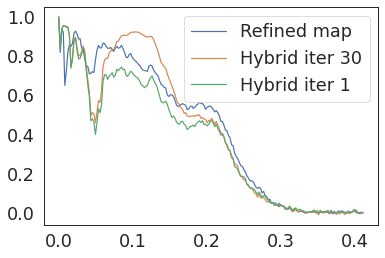

In [58]:
freq_full = frequency_array(fsc_ref, apix=apix)
plt.plot(freq_full, fsc_ref, label="Refined map")
plt.plot(freq_full, fsc_unmasked, label="Hybrid iter 30")
plt.plot(freq_full, fsc_unmasked_1, label="Hybrid iter 1")
plt.legend()


In [52]:
print("FSC of refined map: ", np.mean(fsc_ref))

FSC of refined map:  0.42083688143091663


In [55]:
refined_hybrid_modmap_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/pseudomodel_during_iterations/hybrid_pseudomodel_iterations/overfitting_analysis/refmac_iteration_analysis_output_30/model_maps/model_map_cycle_1.mrc"
fsc_unmasked_1 = calculate_fsc_maps("/home/abharadwaj1/papers/elife_paper/figure_information/data/pseudomodel_during_iterations/hybrid_pseudomodel_iterations/overfitting_analysis/emd_8702_half_map_1.map", refined_hybrid_modmap_path)
print("Fsc average for unmasked map: ", np.mean(fsc_unmasked_1))

Fsc average for unmasked map:  0.3663649678785407


In [48]:
refined_hybrid_modmap_softmask = load_map(refined_hybrid_modmap_path)[0] * softmask
fsc_hybrid_softmask = calculate_fsc_maps(emmap * softmask, refined_hybrid_modmap_softmask)
print("Fsc average for softmasked map: ", np.mean(fsc_hybrid_softmask))

Fsc average for softmasked map:  0.5760808470579274


In [15]:
# Dump the radial profiles to a json file

import json
import pickle 

def jsonify_dictionary(input_dict):
    # convert pickle object to json object
    new_dict = {}
    for key, value in input_dict.items():
        key = str(key) 
        value_is_iterable = isinstance(value, (list, tuple, np.ndarray))
        value_is_dict = isinstance(value, dict)
        value_is_float = isinstance(value, float)
        value_is_int = isinstance(value, (np.int64, int, np.int32))
        value_is_string = isinstance(value, str)

        if value_is_dict:
            new_value = jsonify_dictionary(value)
        elif value_is_iterable:
            new_value = [str(x) for x in value]
        elif not value_is_string:
            new_value = str(value)
        
        new_dict[key] = new_value
        #print("key: {}, value_is_iterable: {}, value_is_dict: {}, value_is_float: {}, value_is_int: {}, value_is_string: {}".format(key, value_is_iterable, value_is_dict, value_is_float, value_is_int, value_is_string))
    
    return new_dict 

radial_profiles_iterations['frequency'] = freq.tolist()

radial_profiles_iterations_json = jsonify_dictionary(radial_profiles_iterations)
output_json_dir = "/home/abharadwaj1/papers/elife_paper/figure_information/data/pseudomodel_during_iterations/hybrid_pseudomodel_iterations/"
output_json_path = os.path.join(output_json_dir,"radial_profiles_iterations_cropped.json")
with open(output_json_path, 'w') as fp:
    json.dump(radial_profiles_iterations_json, fp, indent=4)
output_pickle_path = os.path.join(output_json_dir,"radial_profiles_iterations_cropped.pkl")
with open(output_pickle_path, 'wb') as fp:
    pickle.dump(radial_profiles_iterations, fp, protocol=pickle.HIGHEST_PROTOCOL)


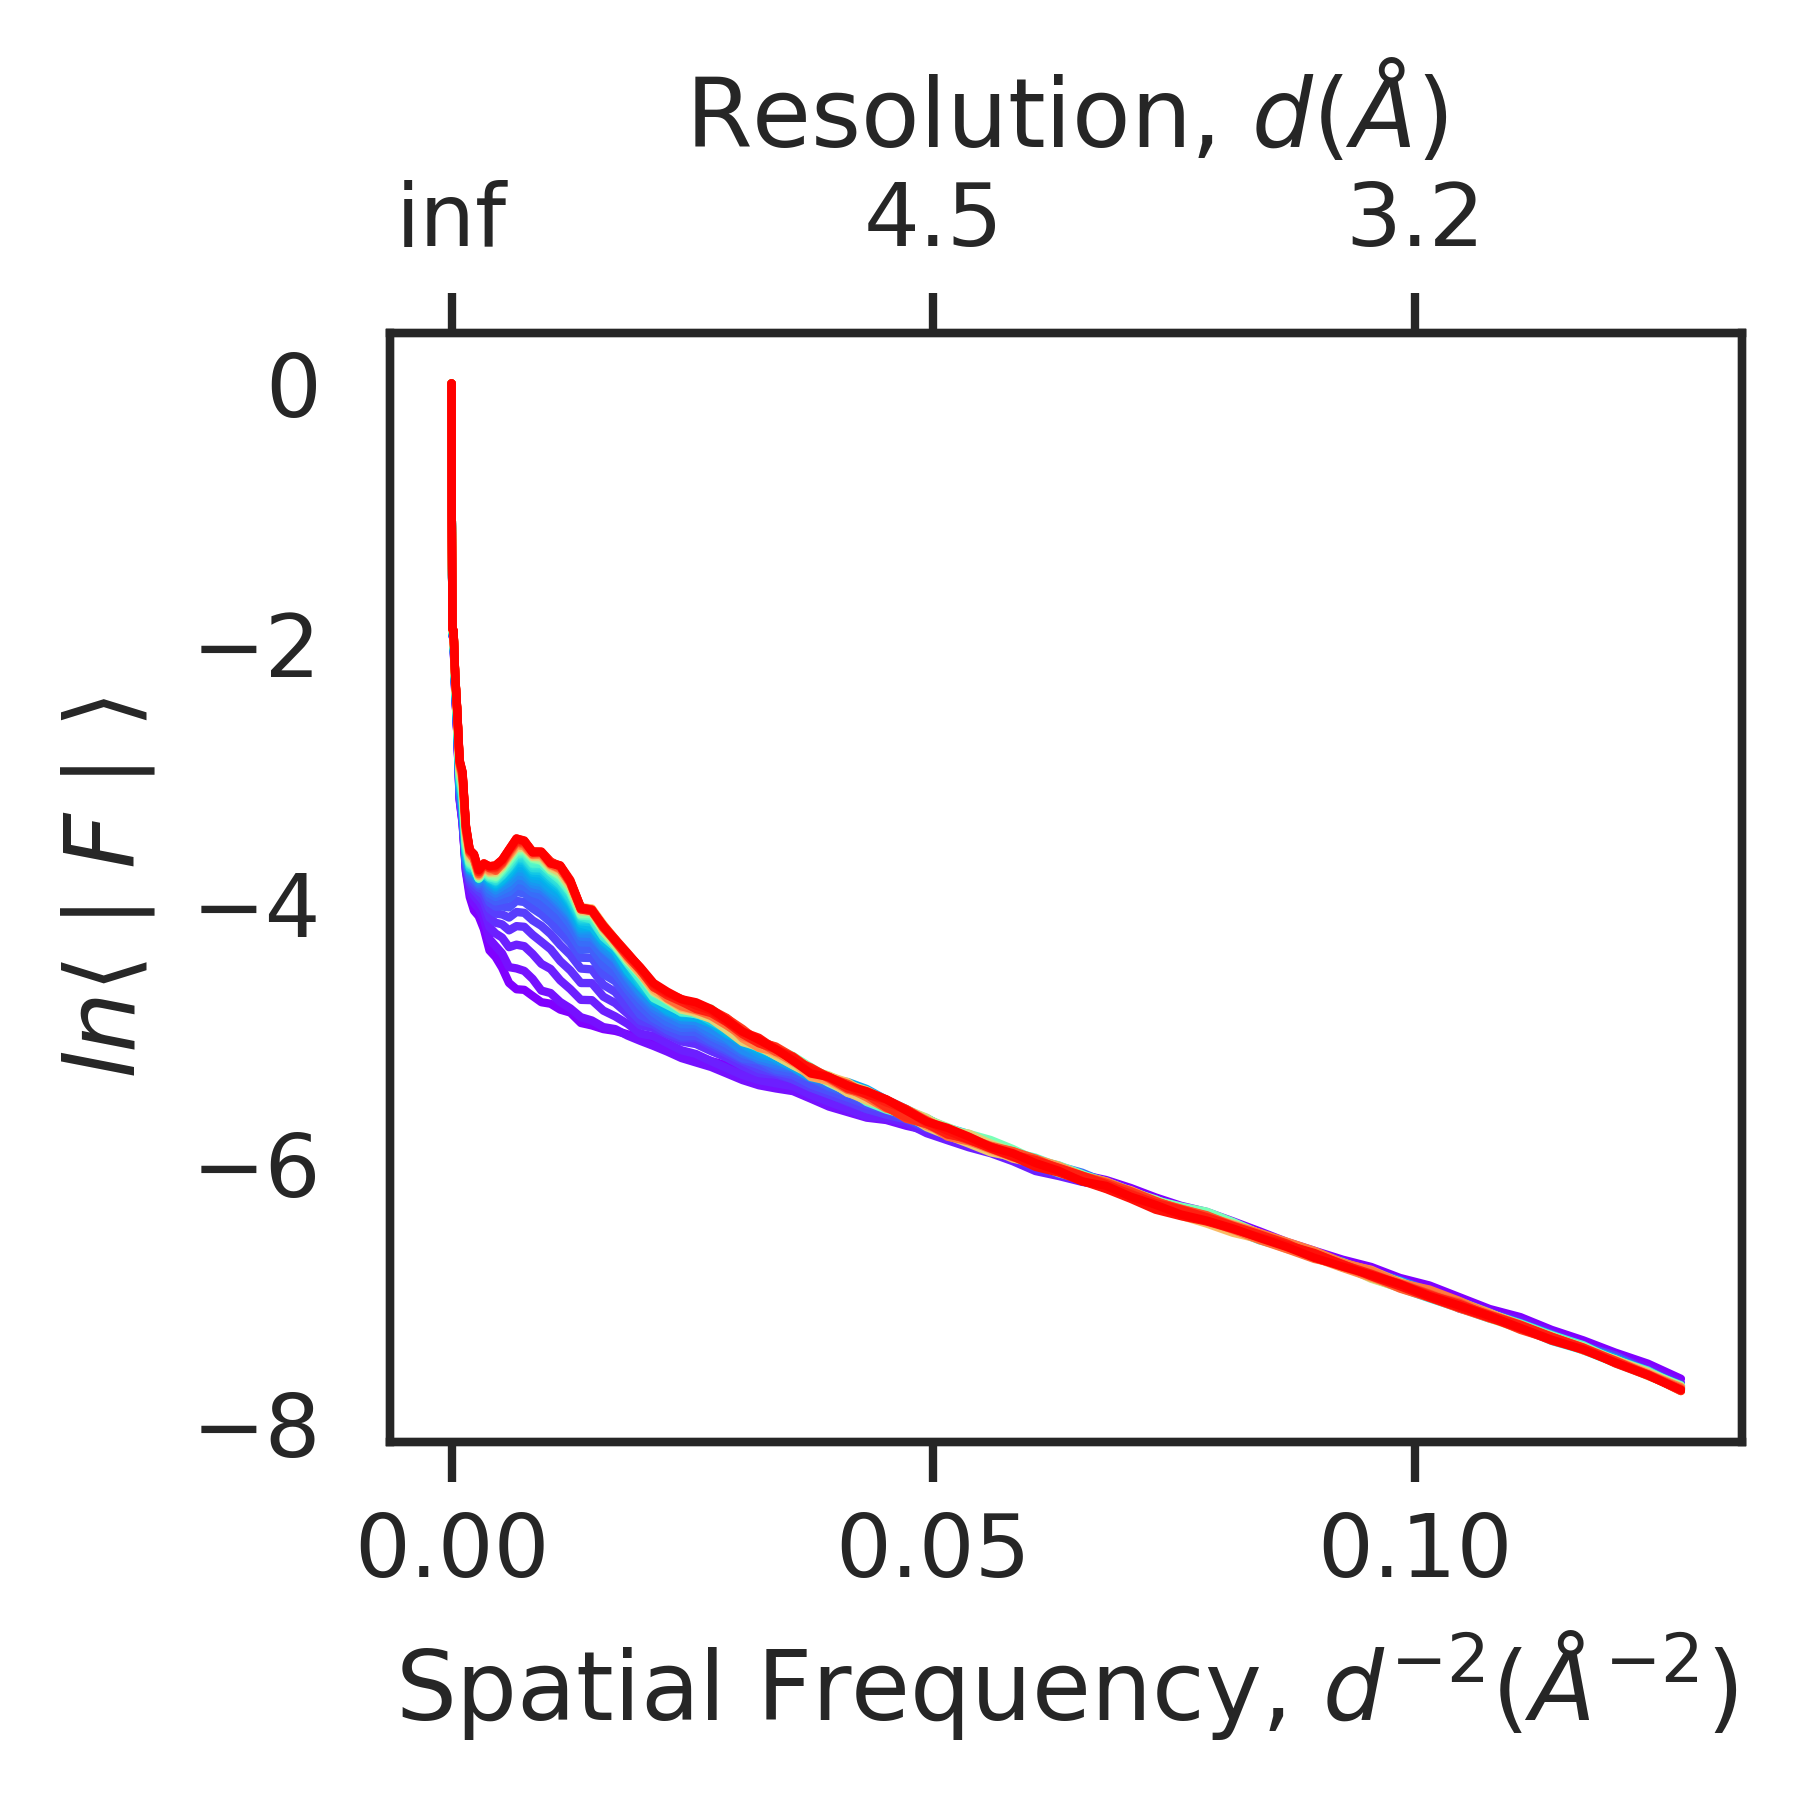

In [88]:
# plot the radial profiles using pretty plot radial profile
from plot_utils import pretty_plot_radial_profile

freq = frequency_array(radial_profiles_iterations[0],apix=1.4)
sharpened_profiles = [radial_profiles_iterations[i] * np.exp(freq * 20 / 4) for i in iterations]
normalised_profiles = [sharpened_profiles[i]/sharpened_profiles[i].max() for i in iterations]
#normalised_profiles += [rp_emmap_norm]
legend_labels = [f"iteration {i}" for i in iterations]
fig = pretty_plot_radial_profile(freq, normalised_profiles,figsize_cm=(8,8), legends=legend_labels,
                                   plot_type="make_log", showlegend=False,fontscale=1.2, linewidth=1)
                                    


In [12]:

rp_emmap = compute_radial_profile(reference_emmap_cropped)
rp_emmap_sharpen = rp_emmap * np.exp(freq * 20 / 4)
rp_emmap_sharpen[0] = rp_emmap_sharpen[0] * 0.55
rp_emmap_norm = rp_emmap_sharpen/rp_emmap_sharpen.max()
#rp_emmap_norm[0] = rp_emmap_norm[1]
fig_emmap = pretty_plot_radial_profile(freq, [rp_emmap_norm],figsize_cm=(8,8), legends=["emmap"],
                                      plot_type="make_log", showlegend=False,fontscale=1.2, linewidth=2)

NameError: name 'freq' is not defined

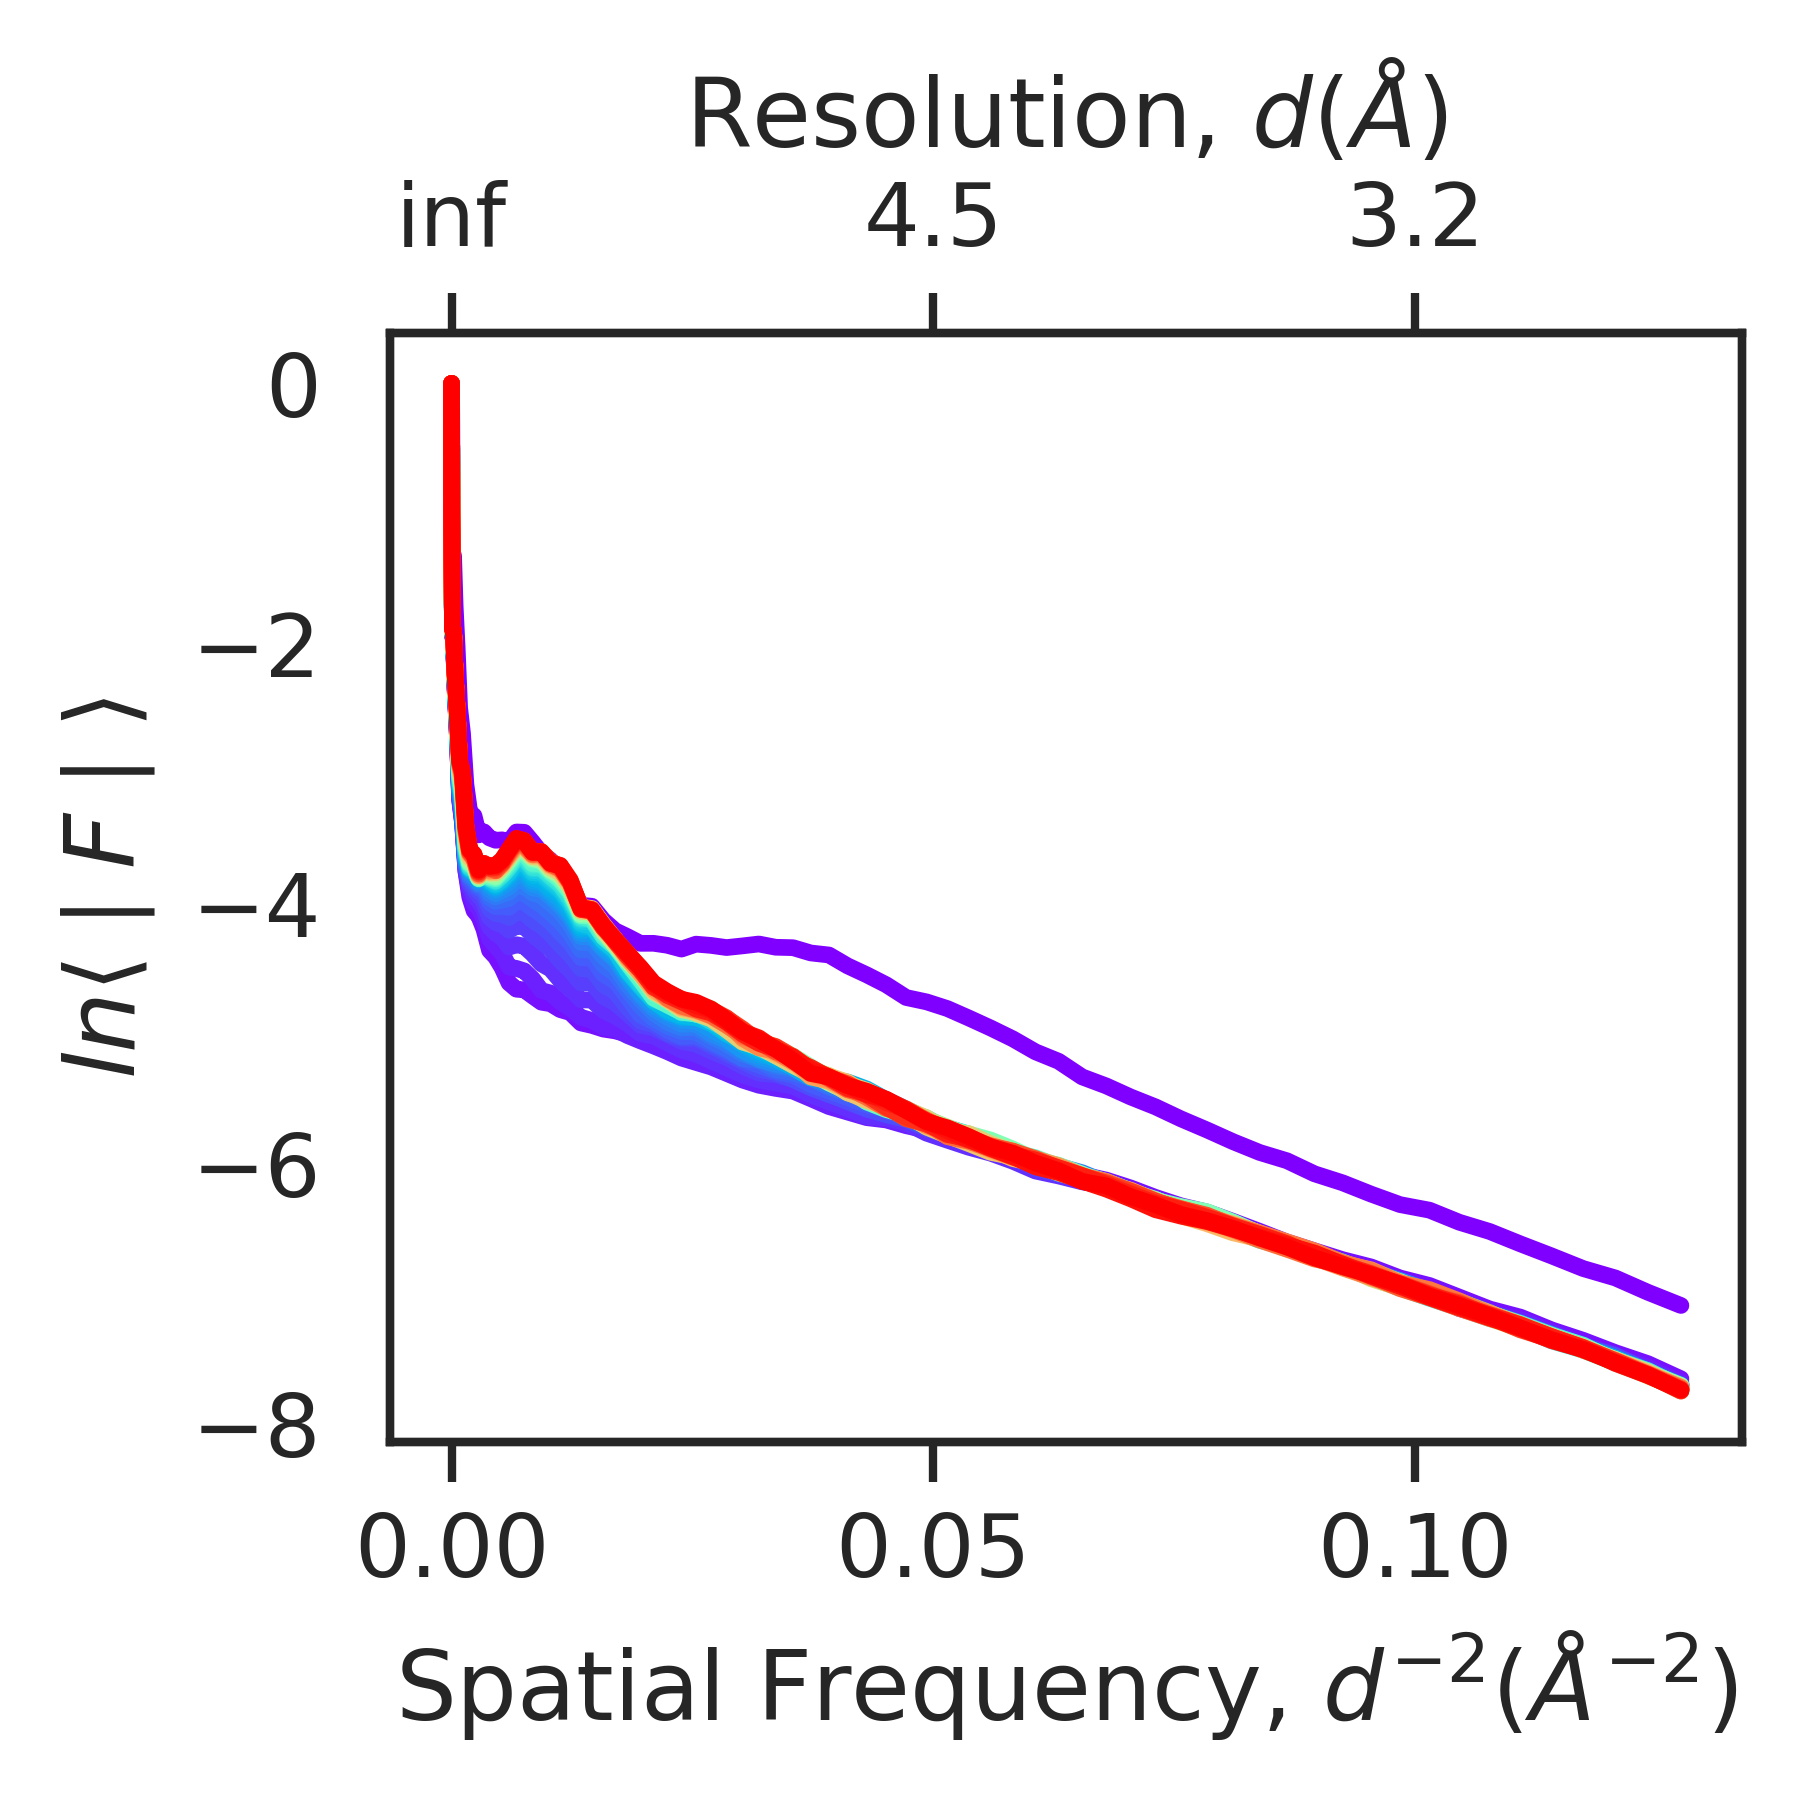

In [90]:
combined_profiles = [rp_emmap_norm] + normalised_profiles
fig_emmap_combined = pretty_plot_radial_profile(freq, combined_profiles,figsize_cm=(8,8), legends=["emmap"]+legend_labels,
                                      plot_type="make_log", showlegend=False,fontscale=1.2, linewidth=2)

In [80]:
plot_output_folder = "/home/abharadwaj1/papers/elife_paper/figure_information/outputs/pseudomodel_iterations_plots"
fig.savefig(os.path.join(plot_output_folder,"figure_radial_profiles_hybrid_iterations.eps"), bbox_inches='tight')
fig_emmap.savefig(os.path.join(plot_output_folder,"figure_radial_profiles_emmap.eps"), bbox_inches='tight')
fig_emmap_combined.savefig(os.path.join(plot_output_folder,"figure_radial_profiles_emmap_combined.eps"), bbox_inches='tight')

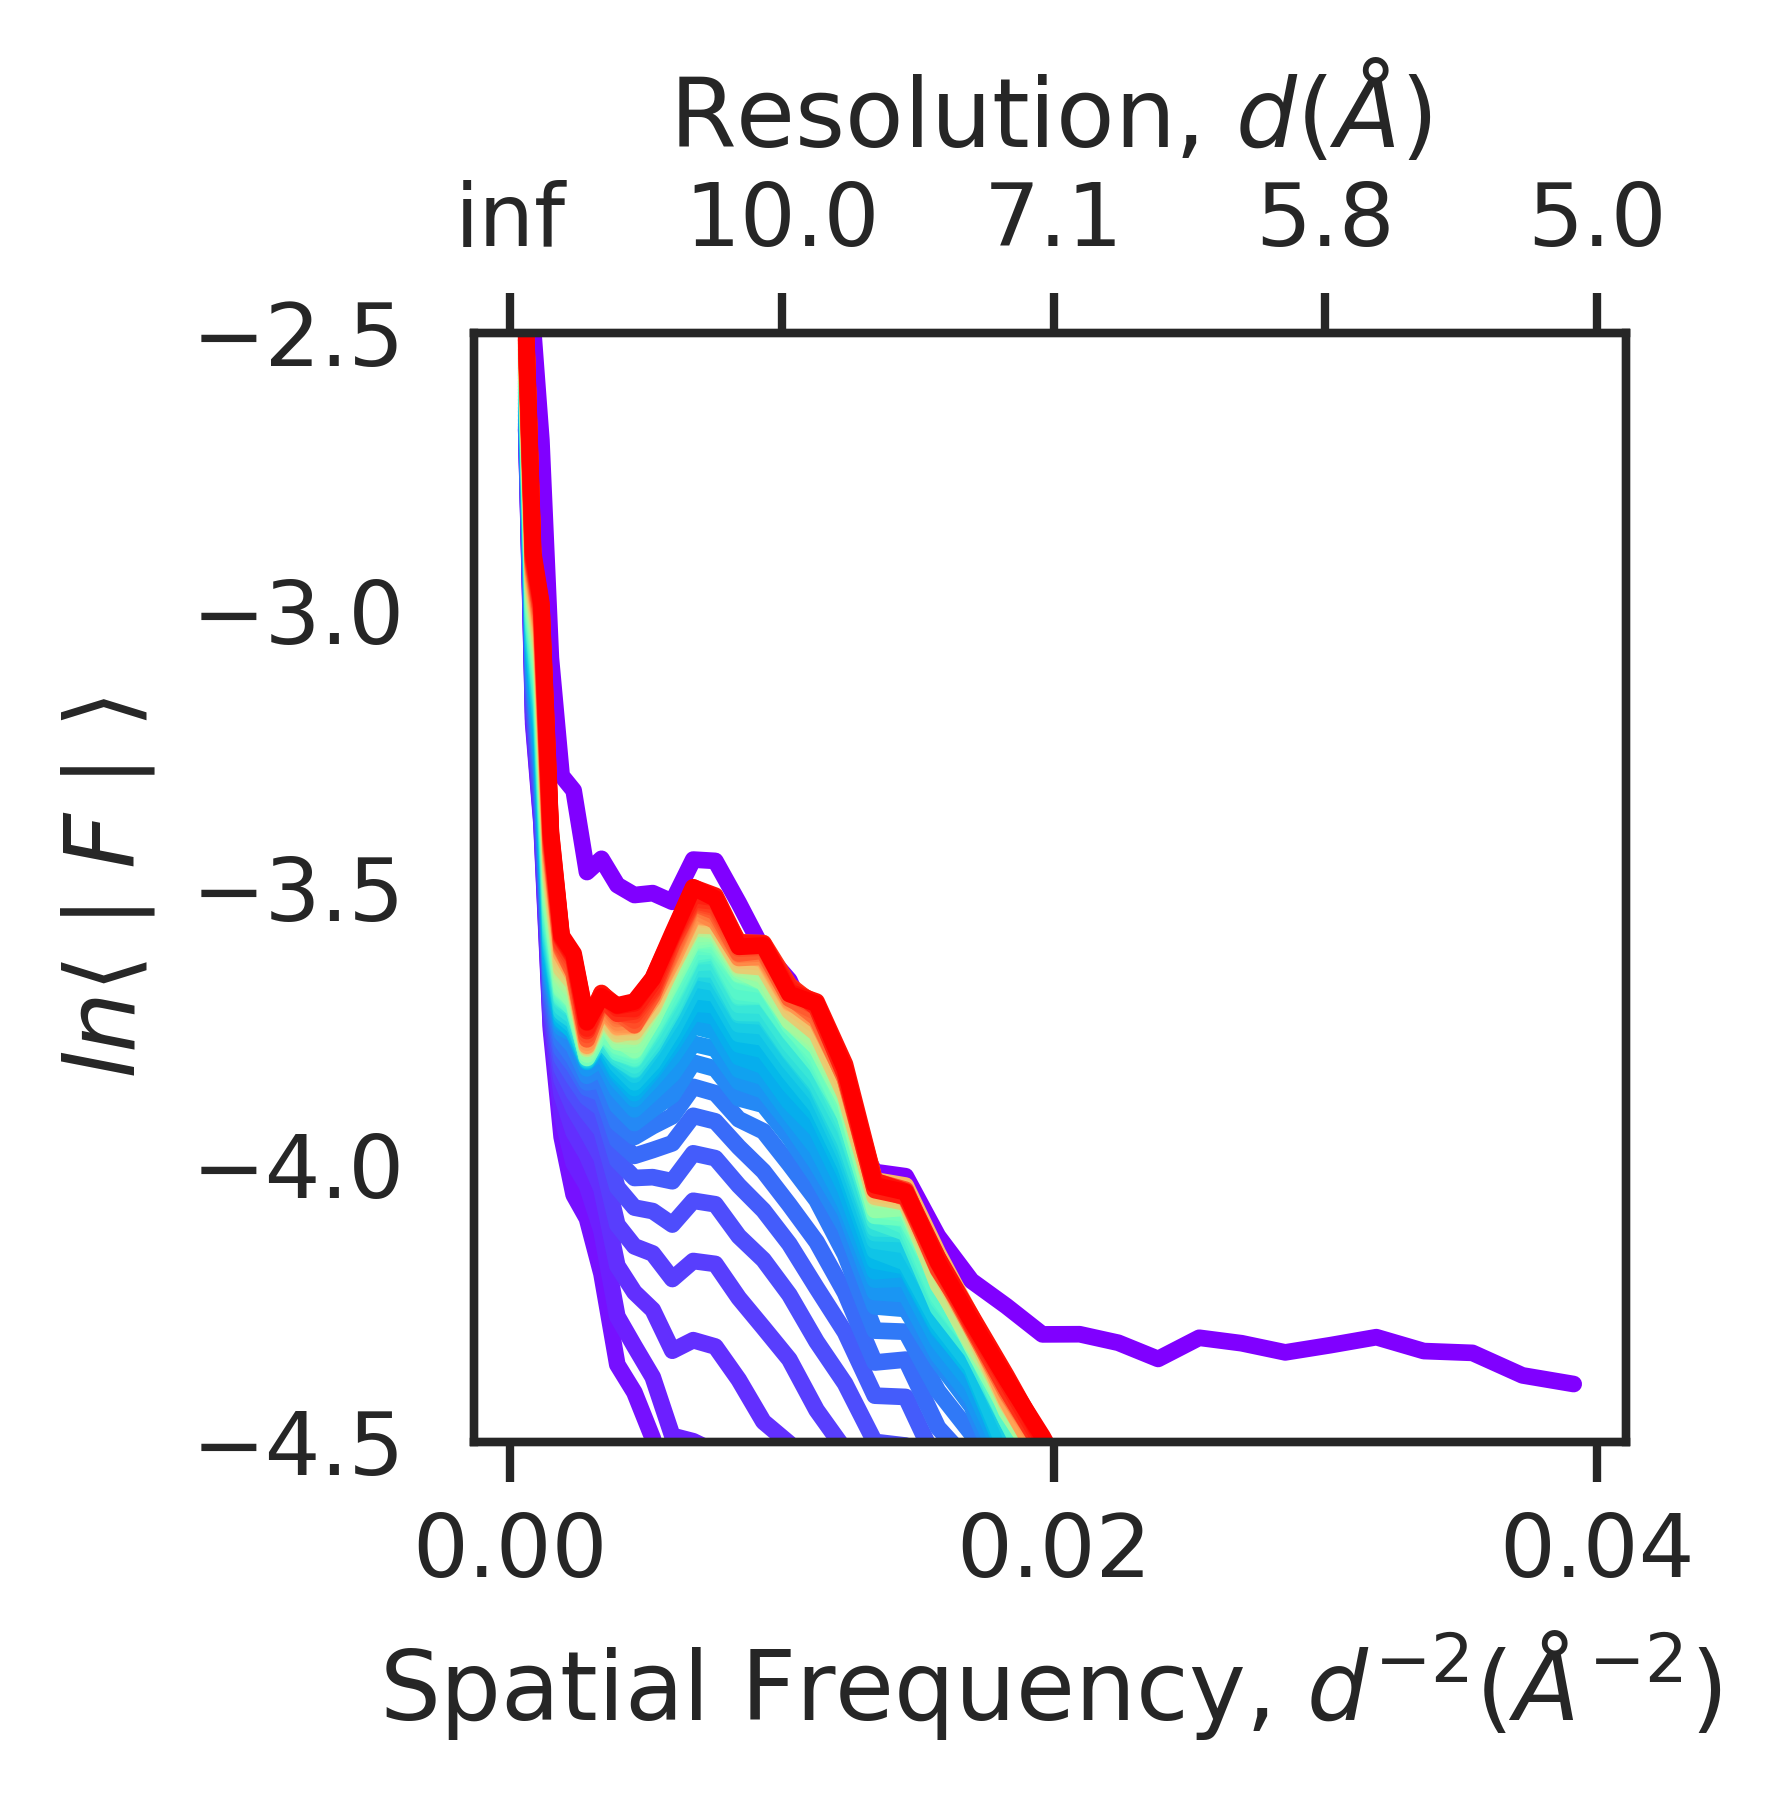

In [91]:
fig_emmap_combined_zoom = pretty_plot_radial_profile(freq, combined_profiles,figsize_cm=(8,8), legends=["emmap"]+legend_labels,
                                      plot_type="make_log", showlegend=False,fontscale=1.2, linewidth=2, crop_freq=[50,5], ylims=[-4.5,-2.5])

In [70]:
fig_emmap_combined_zoom.savefig(os.path.join(plot_output_folder,"figure_radial_profiles_emmap_combined_zoom.eps"), bbox_inches='tight')